# Evaluate model

/home/mk/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


torch.Size([32, 394, 5]) torch.Size([32, 394, 5])


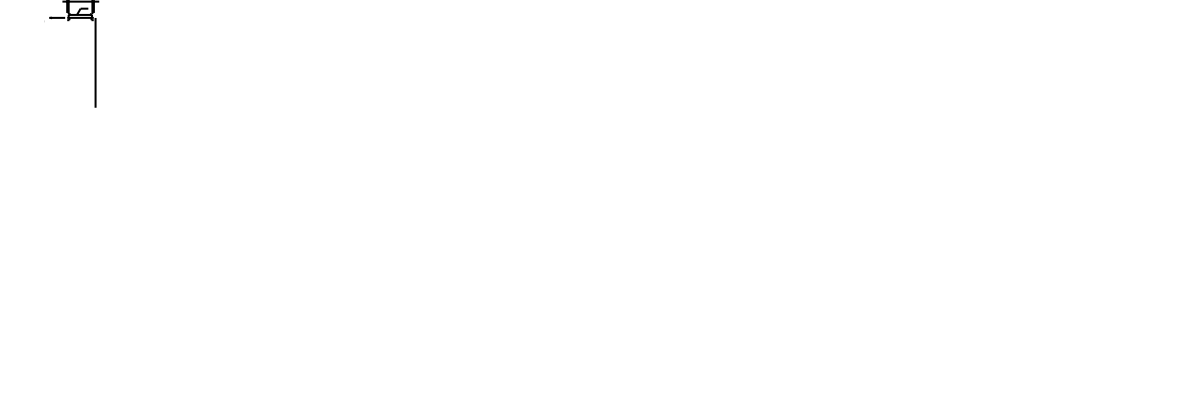

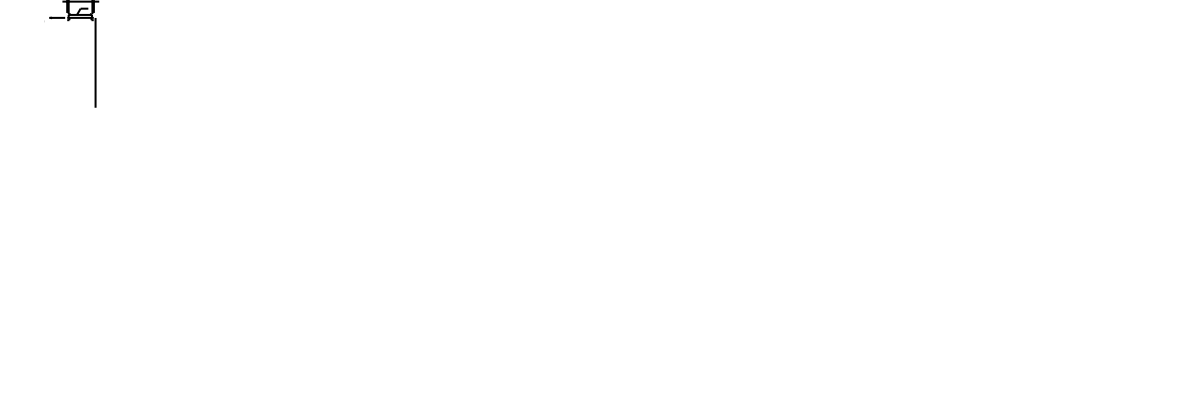

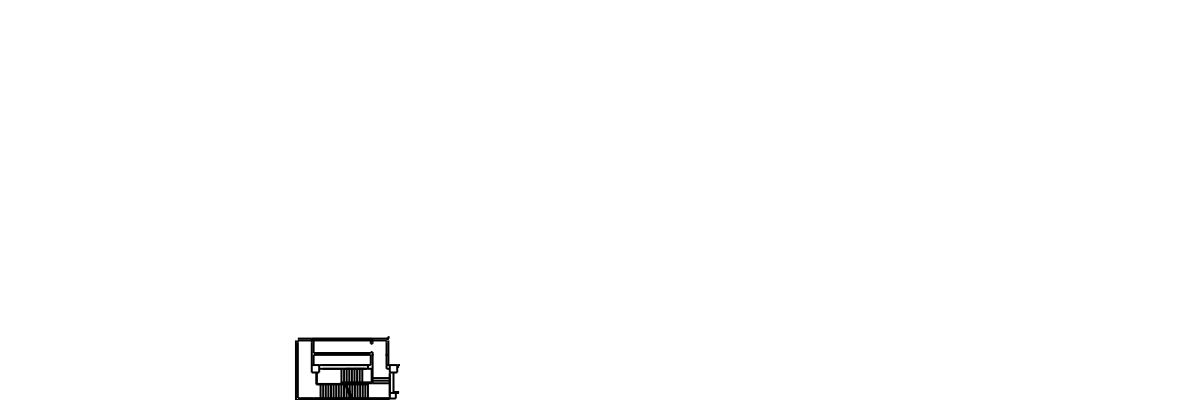

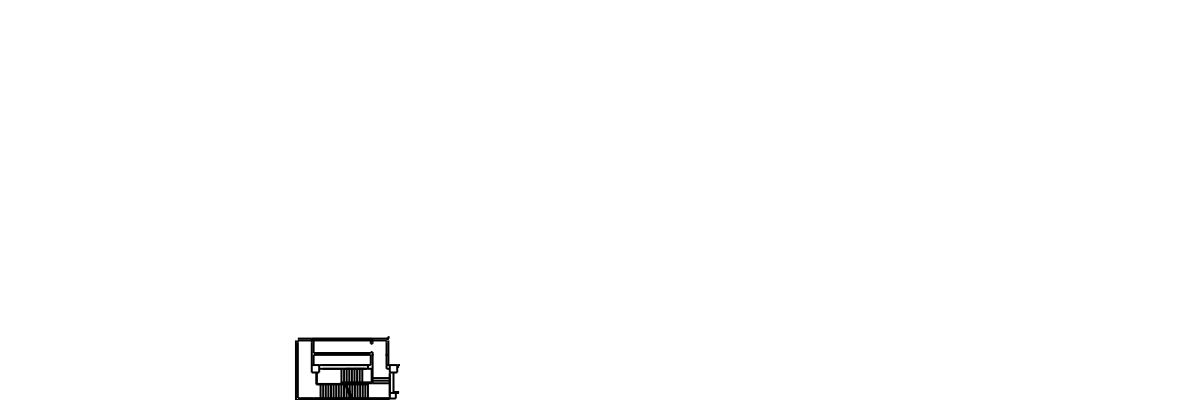

torch.Size([12, 394, 5]) torch.Size([12, 394, 5])


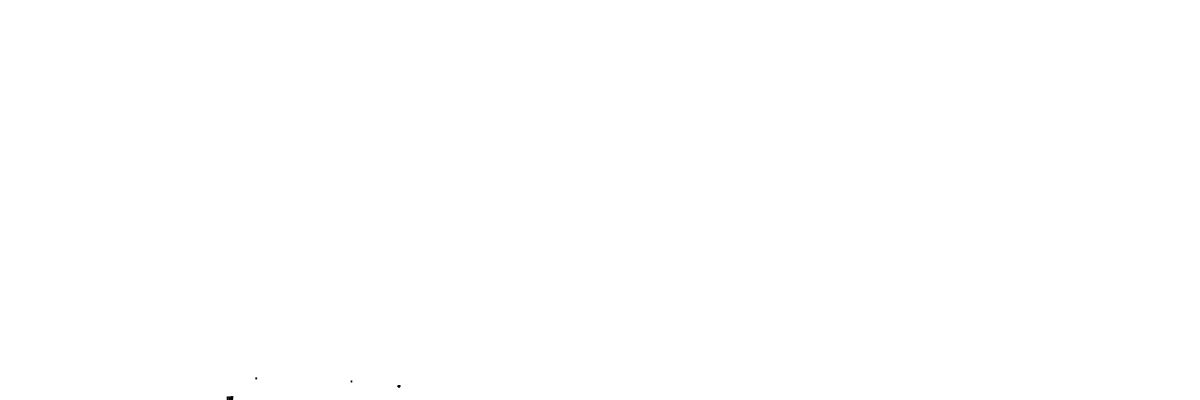

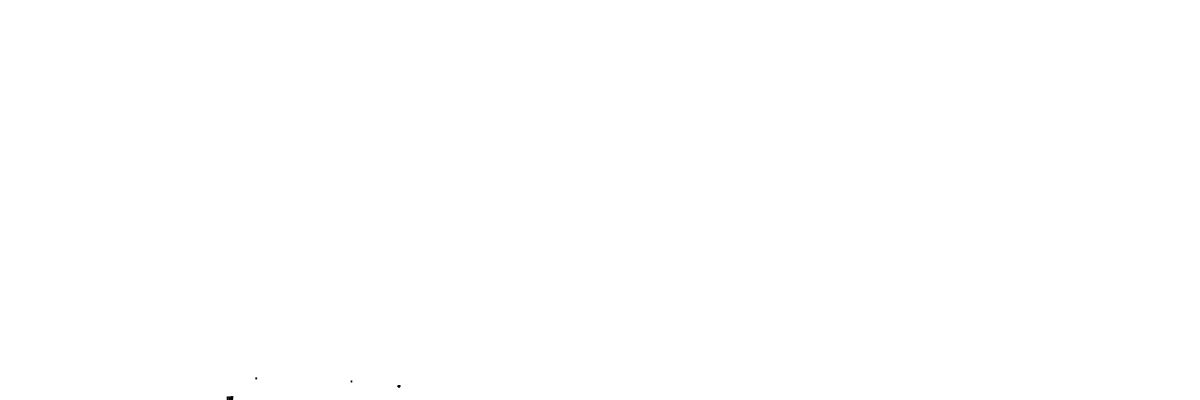

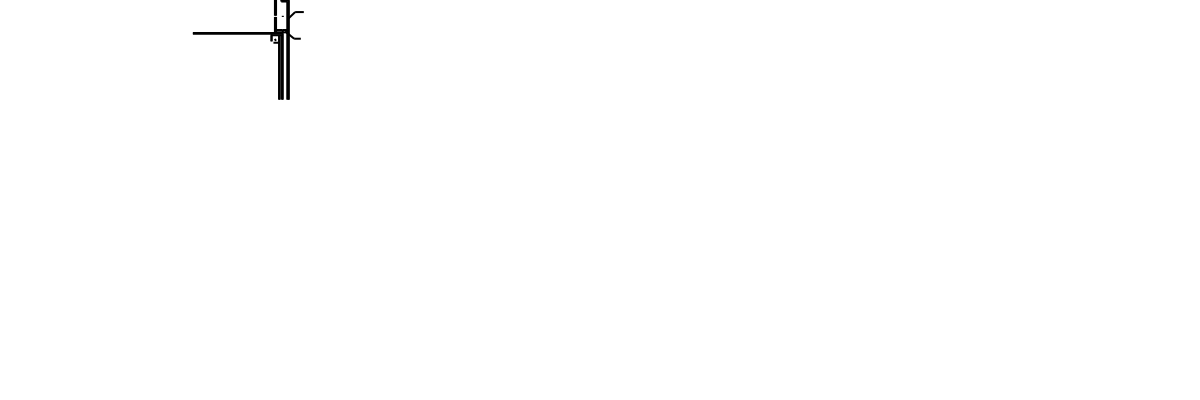

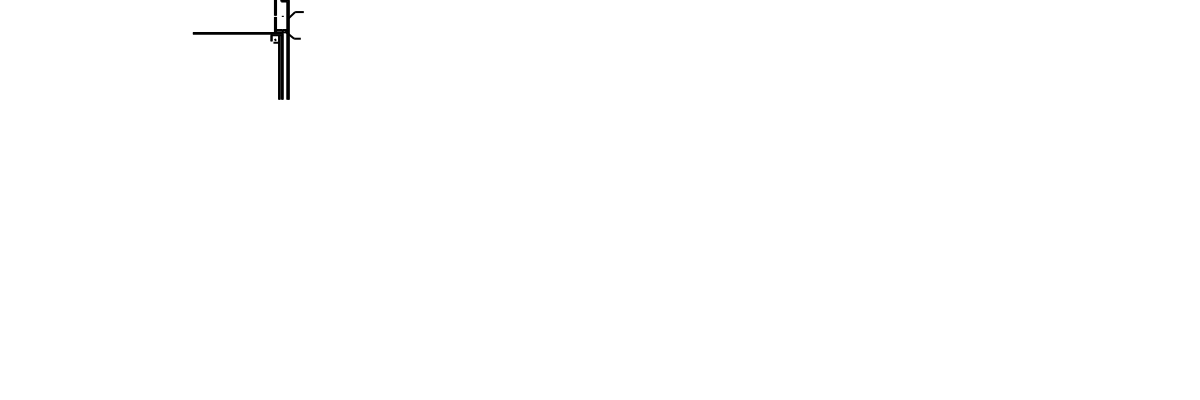

In [9]:
from dataset import DwgDataset
from sketch_rnn import Trainer
from test_draw import generate_sequence
from plot_graphics  import images_from_batch

dwg_dataset = DwgDataset('test_dataset_cluster_labeled.pickle', batch_size = 32, limit_seq_len=200)
trainer = Trainer(dwg_dataset)

for b in dwg_dataset.train_loader:
    
    s = generate_sequence(trainer=trainer, batch=b)
    # print(b[0].shape, s.shape)
    
    source_imgs = images_from_batch(b[0], verbose=False)
    generated_imgs = images_from_batch(s, verbose=False)
    for i in range(len(source_imgs[:2])):
        display(source_imgs[i], generated_imgs[i])